In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 40.4 MB/s eta 0:00:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from darts import TimeSeries
from darts.metrics import mape
from darts.models import (
    ExponentialSmoothing, RandomForest, Theta, LinearRegressionModel,
    RNNModel, TBATS, NHiTSModel
)
from darts.utils.utils import SeasonalityMode, ModelMode
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Data preparation
df = pd.read_csv("monthly-sunspots.csv")
df['Sunspots'] = np.where(df['Sunspots']==0, 1, df['Sunspots'])
df = df[-800:].reset_index(drop=True)
series = TimeSeries.from_dataframe(df, 'Month', 'Sunspots')

# Split data
train, val = series.split_before(pd.Timestamp('19800101'))
print('training set: ', len(train))
print('validation set: ', len(val))

# Transformer for RNN
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)

# Create year covariates
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, end=series.end_time()),
    attribute="year",
    one_hot=False
)
covariates = Scaler().fit_transform(year_series)

# Define models
models = {
    'Exponential Smoothing': ExponentialSmoothing(
        trend=ModelMode.ADDITIVE,
        seasonal=SeasonalityMode.ADDITIVE,
        seasonal_periods=124
    ),
    'Theta': Theta(
        seasonality_period=124,
        season_mode=SeasonalityMode.ADDITIVE
    ),
    'Linear Regression': LinearRegressionModel(
        lags=124,
        output_chunk_length=20
    ),
    'Random Forest': RandomForest(
        lags=[-1, -12, -124],
        output_chunk_length=20,
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        criterion="absolute_error"
    ),
    'RNN': RNNModel(
        model="LSTM",
        training_length=240,
        input_chunk_length=120,
        n_epochs=200,
        batch_size=20,
        optimizer_kwargs={"lr": 1e-3}
    ),
    'TBATS': TBATS(
        seasonal_periods=[12],
        use_box_cox=True,
        use_trend=True,
        use_arma_errors=True
    ),
    'NHiTS': NHiTSModel(
        input_chunk_length=100,
        output_chunk_length=20,
        n_epochs=80
    )
}

# Train models and make predictions
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == 'RNN':
        model.fit(train_transformed, verbose=True)
        pred = model.predict(len(val))
        pred = transformer.inverse_transform(pred)
    else:
        model.fit(train)
        pred = model.predict(len(val))

    # Calculate MAPE
    mape_score = np.round(mape(pred, val), 2)
    results[name] = {'prediction': pred, 'mape': mape_score}

# Create animation

fig = plt.figure(figsize=(15, 7))
ax = plt.axes()

# Set the plot limits
ax.set_xlim(series.time_index.min(), series.time_index.max())
ax.set_ylim(0, series.values().max() * 1.1)

# Plot the actual data
series.plot(label='Actual', ax=ax, color='black', alpha=0.6)

# Initialize empty line objects for each model
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
lines = {}
for (name, color) in zip(models.keys(), colors):
    line, = ax.plot([], [],
                    label=f'{name} (MAPE: {results[name]["mape"]}%)',
                    lw=2,
                    color=color)
    lines[name] = line

plt.title('Sunspots Forecast - All Model Predictions', pad=20)
plt.xlabel('Time')
plt.ylabel('Sunspots')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Animation function
def animate(frame):
    name = list(models.keys())[frame]
    pred = results[name]['prediction']
    lines[name].set_data(pred.time_index, pred.values())
    return lines[name],

# Create animation
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=len(models),
    interval=1000,  # 1 second between frames
    blit=True,
    repeat=True
)

# Save animation
anim.save('model_predictions.gif',
         writer='pillow',
         fps=1,
         dpi=100)
plt.close()

# Print final results
print("\nFinal MAPE Scores:")
for name, result in results.items():
    print(f"{name}: {result['mape']}%")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


training set:  752
validation set:  48

Training Exponential Smoothing...

Training Theta...

Training Linear Regression...

Training Random Forest...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         


Training RNN...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


Training TBATS...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 937 K  | train
-------------------------------------------------------------
885 K     Trainable params
51.3 K    Non-trainable params
937 K     Total params
3.749     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode



Training NHiTS...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


Final MAPE Scores:
Exponential Smoothing: 18.92%
Theta: 19.46%
Linear Regression: 20.03%
Random Forest: 27.94%
RNN: 25.78%
TBATS: 62.13%
NHiTS: 26.06%


In [ ]:
# [Previous code remains the same until the animation part]

# Create animation

fig = plt.figure(figsize=(15, 7))
ax = plt.axes()

# Set the plot limits to start from 1945
start_date = pd.Timestamp('19450101')
ax.set_xlim(start_date, val.time_index.max())
ax.set_ylim(0, series.values().max() * 1.1)

# Get all time indices and values as numpy arrays
all_times = series.time_index.values
all_values = series.values().flatten()

# Create mask for historical data
historical_mask = (all_times >= start_date) & (all_times < val.time_index[0])
historical_line, = ax.plot(all_times[historical_mask],
                          all_values[historical_mask],
                          label='Historical',
                          color='gray',
                          alpha=0.6)

# Initialize empty line objects for each model
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
lines = {}
for (name, color) in zip(models.keys(), colors):
    line, = ax.plot([], [],
                    label=f'{name} (MAPE: {results[name]["mape"]}%)',
                    lw=2,
                    color=color)
    lines[name] = line

# Plot the actual validation data
val_line, = ax.plot([], [], label='Actual', color='black', alpha=0.6)

plt.title('Sunspots Forecast - All Model Predictions', pad=20)
plt.xlabel('Time')
plt.ylabel('Sunspots')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Animation function
def animate(frame):
    # Calculate the current time index
    current_idx = frame + 1  # Add 1 to avoid empty first frame

    # Update actual data
    val_line.set_data(val.time_index[:current_idx],
                      val.values()[:current_idx])

    # Update each model's prediction
    for name in models.keys():
        pred = results[name]['prediction']
        lines[name].set_data(pred.time_index[:current_idx],
                            pred.values()[:current_idx])

    return [val_line] + list(lines.values())

# Create animation
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=len(val),  # Number of frames is the length of validation set
    interval=50,      # 50ms between frames for smoother animation
    blit=True,
    repeat=True
)

# Save animation
anim.save('model_predictions.gif',
         writer='pillow',
         fps=20,      # Increased fps for smoother animation
         dpi=100)
plt.close()

# Print final results
print("\nFinal MAPE Scores:")
for name, result in results.items():
    print(f"{name}: {result['mape']}%")



Final MAPE Scores:
Exponential Smoothing: 18.92%
Theta: 19.46%
Linear Regression: 20.03%
Random Forest: 27.94%
RNN: 25.78%
TBATS: 62.13%
NHiTS: 26.06%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Load the datasets
train_data = pd.read_csv('Exoplanets-Training-Data.csv')
test_data = pd.read_csv('Exoplanets-Batch-Test.csv')

# Separate features and target variables
X_train = train_data.drop(['Has Planet'], axis=1)
y_train = train_data['Has Planet']

X_test = test_data.drop(['Has Planet (real)'], axis=1)
y_test = test_data['Has Planet (real)']

# Create and train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance['importance'])
plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=45)
plt.title('Feature Importance in Planet Detection')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Plot confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()





Model Performance:
-----------------
Accuracy: 0.9921

Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      1.00      1010
           2       0.00      0.00      0.00         8

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.98      0.99      0.99      1018



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


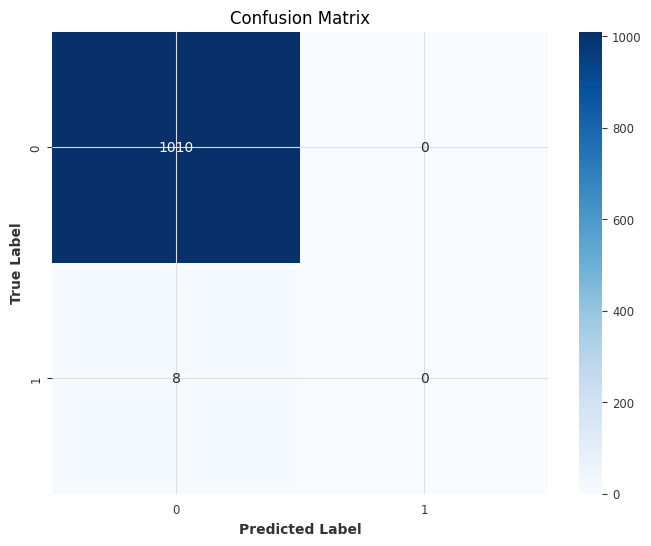

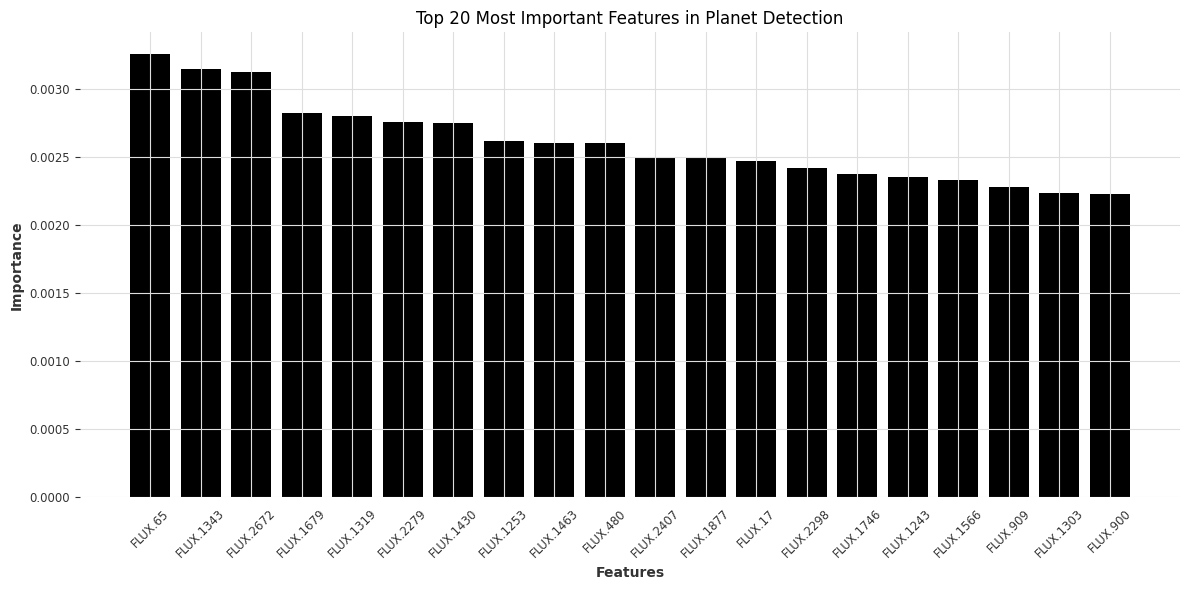

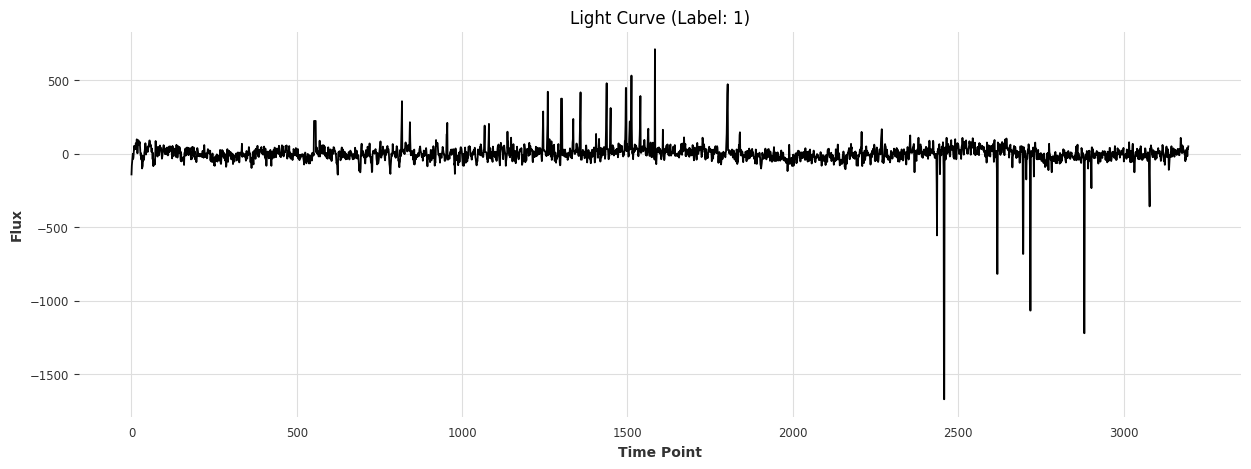

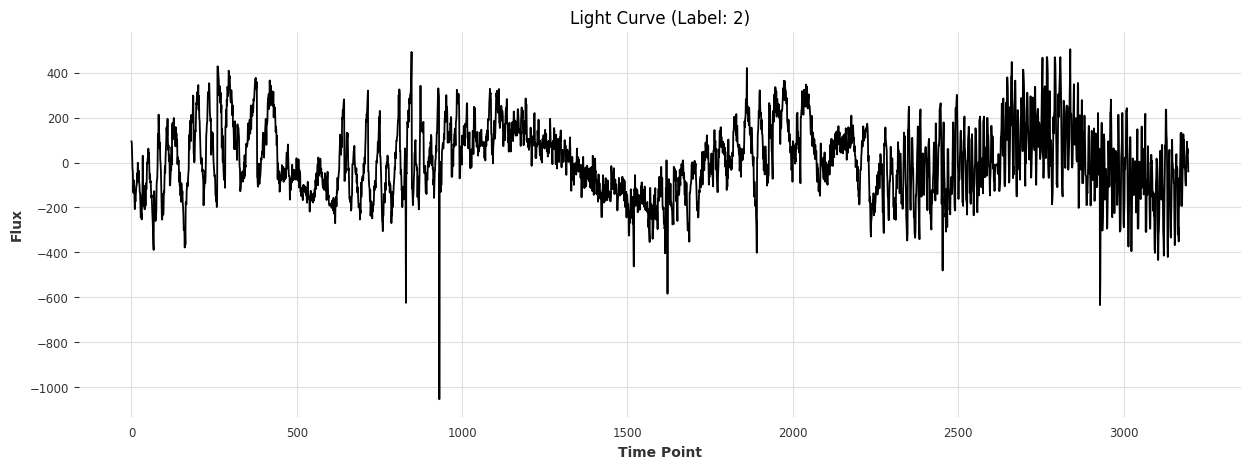

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load and prepare the data
def prepare_data(data):
    # Separate features (FLUX columns) and target (LABEL)
    X = data.drop('LABEL', axis=1)
    y = data['LABEL']
    return X, y

# Load the data
data = pd.read_csv('exoTrain.csv')

# Split features and target
X, y = prepare_data(data)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Print model performance
print("Model Performance:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
plt.bar(range(20), feature_importance['importance'][:20])
plt.xticks(range(20), feature_importance['feature'][:20], rotation=45)
plt.title('Top 20 Most Important Features in Planet Detection')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Plot light curve for a sample
def plot_light_curve(data, index):
    flux_values = data.iloc[index, 1:]  # Skip the LABEL column
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(flux_values)), flux_values)
    plt.title(f'Light Curve (Label: {data.iloc[index, 0]})')
    plt.xlabel('Time Point')
    plt.ylabel('Flux')
    plt.grid(True)
    plt.show()

# Plot example light curves for both classes
for label in [1, 2]:  # Assuming labels are 1 and 2
    sample_index = data[data['LABEL'] == label].index[0]
    plot_light_curve(data, sample_index)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from darts import TimeSeries
from darts.metrics import mape
from darts.models import (
    ExponentialSmoothing, RandomForest, Theta, LinearRegressionModel,
    TBATS, NHiTSModel
)
from darts.utils.utils import SeasonalityMode, ModelMode

# Data preparation
df = pd.read_csv("monthly-sunspots.csv")
df['Sunspots'] = np.where(df['Sunspots']==0, 1, df['Sunspots'])
df = df[-800:].reset_index(drop=True)

# Convert to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Resample to yearly frequency
df_yearly = df.resample('Y').mean()
series = TimeSeries.from_dataframe(df_yearly, value_cols='Sunspots')

# Split data
train, val = series.split_before(pd.Timestamp('19800101'))
print('training set: ', len(train))
print('validation set: ', len(val))

# Define models
models = {
    'Exponential Smoothing': ExponentialSmoothing(
        trend=ModelMode.ADDITIVE,
        seasonal=SeasonalityMode.ADDITIVE,
        seasonal_periods=11
    ),
    'Theta': Theta(
        seasonality_period=11,
        season_mode=SeasonalityMode.ADDITIVE
    ),
    'Linear Regression': LinearRegressionModel(
        lags=11,
        output_chunk_length=20
    ),
    'Random Forest': RandomForest(
        lags=[-1, -2, -11],
        output_chunk_length=20,
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        criterion="absolute_error"
    ),
    'TBATS': TBATS(
        seasonal_periods=[11],
        use_box_cox=True,
        use_trend=True,
        use_arma_errors=True
    ),
    'NHiTS': NHiTSModel(
        input_chunk_length=10,
        output_chunk_length=20,
        n_epochs=80
    )
}

# Train models and make predictions
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(train)
    pred = model.predict(20)  # 20 years into future
    results[name] = {'prediction': pred}

# Create animation

fig = plt.figure(figsize=(15, 7))
ax = plt.axes()

# Set the plot limits to start from 1945
start_date = pd.Timestamp('19450101')
end_date = results[list(models.keys())[0]]['prediction'].time_index[-1]  # Use the end of prediction period

# Convert series to pandas DataFrame for easier plotting
historical_df = series.pd_dataframe()
historical_df = historical_df[historical_df.index >= start_date]

# Plot historical data
ax.plot(historical_df.index, historical_df.values,
        label='Historical', color='black', alpha=0.6)

# Set axis limits
ax.set_xlim(start_date, end_date)
ax.set_ylim(0, series.values().max() * 1.1)

# Initialize empty line objects for each model
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
lines = {}
for (name, color) in zip(models.keys(), colors):
    line, = ax.plot([], [], label=f'{name}', lw=2, color=color)
    lines[name] = line

plt.title('Yearly Sunspots Forecast - 20 Years into Future', pad=20)
plt.xlabel('Time')
plt.ylabel('Sunspots')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

def animate(frame):
    current_idx = frame + 1

    # Update each model's prediction
    for name in models.keys():
        pred = results[name]['prediction']
        lines[name].set_data(pred.time_index[:current_idx],
                            pred.values()[:current_idx])

    return list(lines.values())

# Create animation
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=20,  # 20 years of predictions
    interval=200,  # 200ms between frames
    blit=True,
    repeat=True
)

# Save animation
anim.save('sunspots_forecast.gif',
         writer='pillow',
         fps=5,
         dpi=100)
plt.close()

# Print the final predicted values for each model
print("\nFinal predicted values (20 years into future):")
for name, result in results.items():
    final_value = result['prediction'].values()[-1][0]
    print(f"{name}: {final_value:.2f}")


<ipython-input-12-c39b26ece26e>:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').mean()


training set:  63
validation set:  4

Training Exponential Smoothing...

Training Theta...

Training Linear Regression...

Training Random Forest...

Training TBATS...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 819 K  | train
-------------------------------------------------------------
814 K     Trainable params
5.1 K     Non-trainable params
819 K     Total params
3.279     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode



Training NHiTS...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


Final predicted values (20 years into future):
Exponential Smoothing: 86.92
Theta: 82.34
Linear Regression: 100.76
Random Forest: 118.68
TBATS: 52.69
NHiTS: 91.02


<ipython-input-16-1aa6cc2beec9>:22: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').mean()


training set:  63
validation set:  4

Training Exponential Smoothing...

Training Theta...

Training Linear Regression...

Training Random Forest...

Training TBATS...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 819 K  | train
-------------------------------------------------------------
814 K     Trainable params
5.1 K     Non-trainable params
819 K     Total params
3.279     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode



Training NHiTS...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

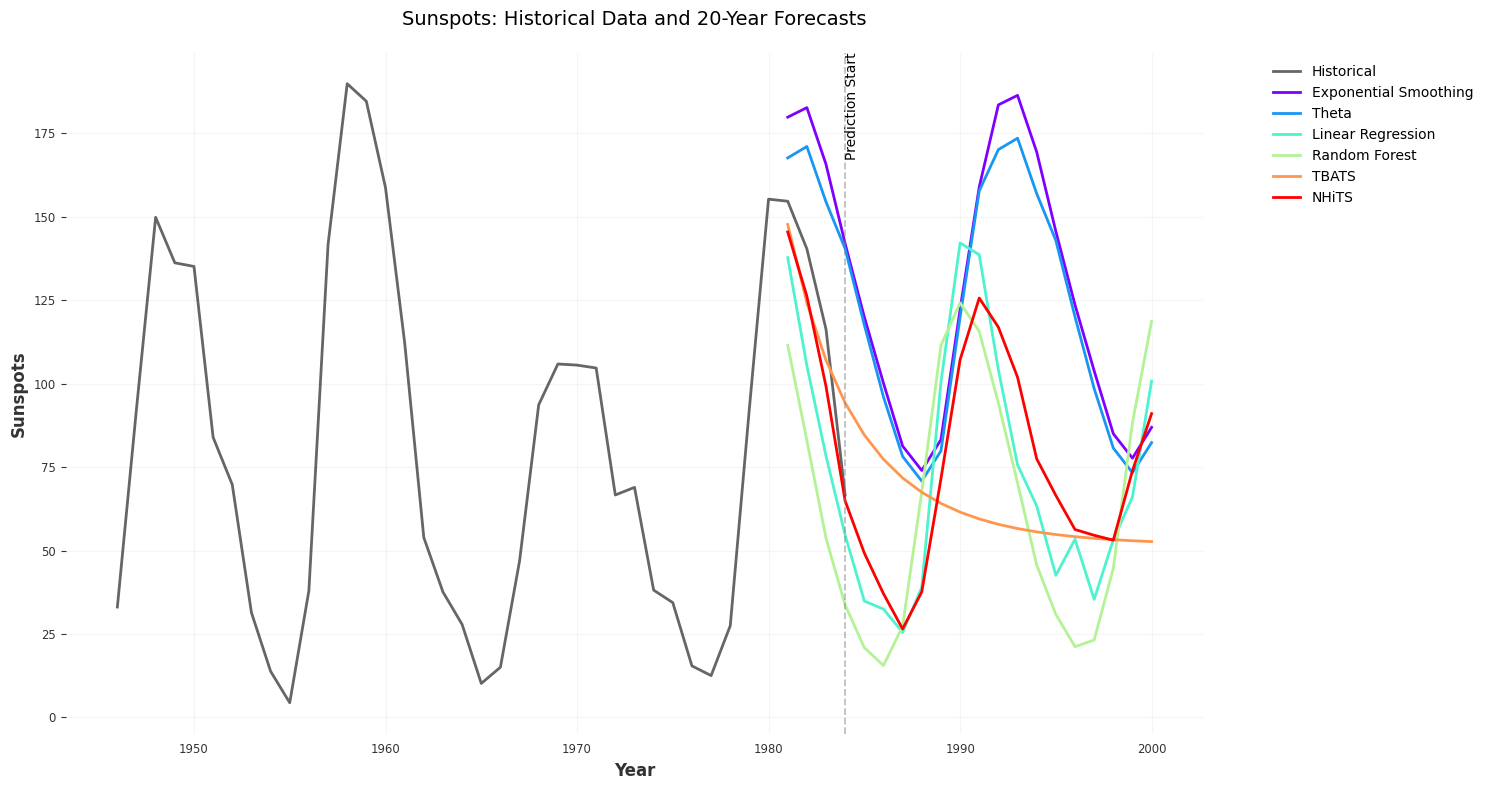


Final predicted values (20 years into future):
Exponential Smoothing: 86.92
Theta: 82.34
Linear Regression: 100.76
Random Forest: 118.68
TBATS: 52.69
NHiTS: 91.02


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape
from darts.models import (
    ExponentialSmoothing, RandomForest, Theta, LinearRegressionModel,
    TBATS, NHiTSModel
)
from darts.utils.utils import SeasonalityMode, ModelMode

# Data preparation
df = pd.read_csv("monthly-sunspots.csv")
df['Sunspots'] = np.where(df['Sunspots']==0, 1, df['Sunspots'])
df = df[-800:].reset_index(drop=True)

# Convert to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Resample to yearly frequency
df_yearly = df.resample('Y').mean()
series = TimeSeries.from_dataframe(df_yearly, value_cols='Sunspots')

# Split data
train, val = series.split_before(pd.Timestamp('19800101'))
print('training set: ', len(train))
print('validation set: ', len(val))

# Define models
models = {
    'Exponential Smoothing': ExponentialSmoothing(
        trend=ModelMode.ADDITIVE,
        seasonal=SeasonalityMode.ADDITIVE,
        seasonal_periods=11
    ),
    'Theta': Theta(
        seasonality_period=11,
        season_mode=SeasonalityMode.ADDITIVE
    ),
    'Linear Regression': LinearRegressionModel(
        lags=11,
        output_chunk_length=20
    ),
    'Random Forest': RandomForest(
        lags=[-1, -2, -11],
        output_chunk_length=20,
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        criterion="absolute_error"
    ),
    'TBATS': TBATS(
        seasonal_periods=[11],
        use_box_cox=True,
        use_trend=True,
        use_arma_errors=True
    ),
    'NHiTS': NHiTSModel(
        input_chunk_length=10,
        output_chunk_length=20,
        n_epochs=80
    )
}

# Train models and make predictions
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(train)
    pred = model.predict(20)  # 20 years into future
    results[name] = {'prediction': pred}

# Create final static plot
plt.figure(figsize=(15, 8))


# Plot historical data
start_date = pd.Timestamp('19450101')
historical_df = series.pd_dataframe()
historical_df = historical_df[historical_df.index >= start_date]
plt.plot(historical_df.index, historical_df.values,
         label='Historical', color='black', alpha=0.6, linewidth=2)

# Plot predictions for each model
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
for (name, color) in zip(models.keys(), colors):
    pred = results[name]['prediction']
    plt.plot(pred.time_index, pred.values(),
             label=f'{name}', color=color, linewidth=2)

# Add vertical line at the start of predictions
prediction_start = historical_df.index[-1]
plt.axvline(x=prediction_start, color='gray', linestyle='--', alpha=0.5)
plt.text(prediction_start, plt.ylim()[1], 'Prediction Start',
         rotation=90, verticalalignment='top')

# Customize the plot
plt.title('Sunspots: Historical Data and 20-Year Forecasts', pad=20, size=14)
plt.xlabel('Year', size=12)
plt.ylabel('Sunspots', size=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig('sunspots_all_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print the final predicted values for each model
print("\nFinal predicted values (20 years into future):")
for name, result in results.items():
    final_value = result['prediction'].values()[-1][0]
    print(f"{name}: {final_value:.2f}")


In [ ]:
# Calculate number of years to predict (from 1980 to 2026)
end_date = pd.Timestamp('20260101')
train_end = train.time_index[-1]
years_to_predict = (end_date.year - train_end.year) + 1

# Train models and make predictions
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(train)
    pred = model.predict(years_to_predict)  # predict until 2026
    results[name] = {'prediction': pred}

# Extract January 2025 predictions
target_date = pd.Timestamp('20250101')
predictions_2025 = {}

for name, result in results.items():
    pred_df = result['prediction'].pd_dataframe()
    # Get the value for 2025
    value_2025 = pred_df.loc[target_date]['Sunspots']
    predictions_2025[name] = value_2025

# Print predictions and calculate mean
print("\nPredictions for January 2025:")
total = 0
for name, value in predictions_2025.items():
    print(f"{name}: {value:.2f}")
    total += value

mean_prediction = total / len(predictions_2025)
print(f"\nMean prediction for January 2025: {mean_prediction:.2f}")



Training Exponential Smoothing...

Training Theta...

Training Linear Regression...

Training Random Forest...

Training TBATS...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 819 K  | train
-------------------------------------------------------------
814 K     Trainable params
5.1 K     Non-trainable params
819 K     Total params
3.279     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode



Training NHiTS...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

KeyError: Timestamp('2025-01-01 00:00:00')


Training Exponential Smoothing...

Training Theta...

Training Linear Regression...

Training Random Forest...

Training TBATS...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 819 K  | train
-------------------------------------------------------------
814 K     Trainable params
5.1 K     Non-trainable params
819 K     Total params
3.279     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode



Training NHiTS...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


Predictions for 2025:
Exponential Smoothing: 197.42
Theta: 180.98
Linear Regression: 7.36
Random Forest: 56.95
TBATS: 51.68
NHiTS: 39.73

Mean prediction for 2025: 89.02


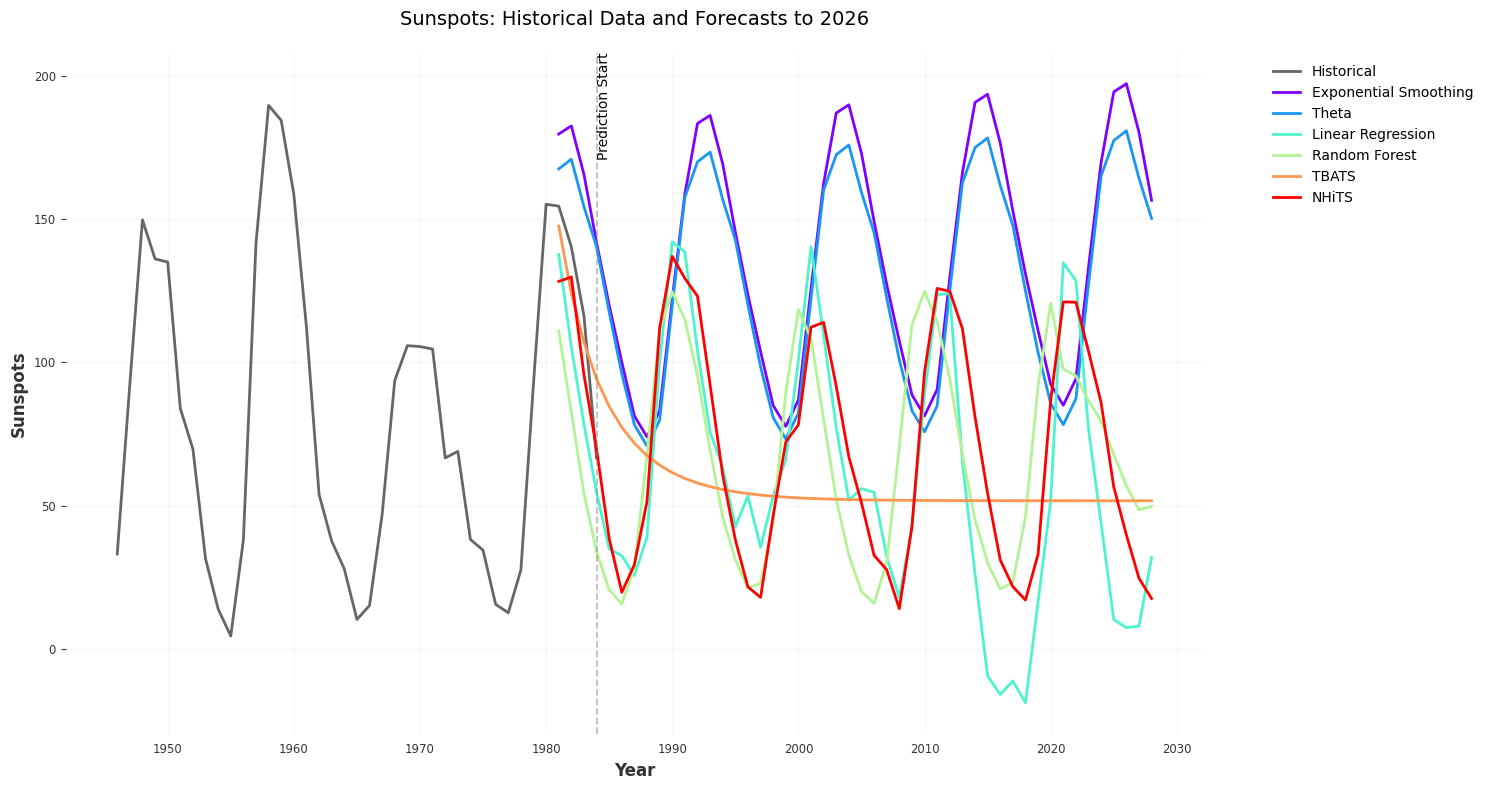

In [ ]:
# Calculate number of years to predict (from 1980 to 2026)
end_date = pd.Timestamp('20260101')
train_end = train.time_index[-1]
years_to_predict = (end_date.year - train_end.year) + 1

# Train models and make predictions
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(train)
    pred = model.predict(years_to_predict)  # predict until 2026
    results[name] = {'prediction': pred}

# Extract 2025 predictions
predictions_2025 = {}

for name, result in results.items():
    pred_df = result['prediction'].pd_dataframe()
    # Get the value for 2025 (get the first value in 2025)
    value_2025 = pred_df[pred_df.index.year == 2025].iloc[0]['Sunspots']
    predictions_2025[name] = value_2025

# Print predictions and calculate mean
print("\nPredictions for 2025:")
total = 0
for name, value in predictions_2025.items():
    print(f"{name}: {value:.2f}")
    total += value

mean_prediction = total / len(predictions_2025)
print(f"\nMean prediction for 2025: {mean_prediction:.2f}")

# Create final static plot
plt.figure(figsize=(15, 8))


# Plot historical data
start_date = pd.Timestamp('19450101')
historical_df = series.pd_dataframe()
historical_df = historical_df[historical_df.index >= start_date]
plt.plot(historical_df.index, historical_df.values,
         label='Historical', color='black', alpha=0.6, linewidth=2)

# Plot predictions for each model
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
for (name, color) in zip(models.keys(), colors):
    pred = results[name]['prediction']
    plt.plot(pred.time_index, pred.values(),
             label=f'{name}', color=color, linewidth=2)

# Add vertical line at the start of predictions
prediction_start = historical_df.index[-1]
plt.axvline(x=prediction_start, color='gray', linestyle='--', alpha=0.5)
plt.text(prediction_start, plt.ylim()[1], 'Prediction Start',
         rotation=90, verticalalignment='top')

# Customize the plot
plt.title('Sunspots: Historical Data and Forecasts to 2026', pad=20, size=14)
plt.xlabel('Year', size=12)
plt.ylabel('Sunspots', size=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig('sunspots_all_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
